In [1]:
using ArenaSim
using Statistics
using Distributions
using DataStructures
using Dates
using PyPlot
import Random

In [2]:
basedir = joinpath(@__DIR__, "decks", "distribution")
subdirs = readdir(basedir)
decks = OrderedDict{Date,Vector{ArenaSim.Deckinfo}}()
decksfull = OrderedDict{Date,Vector{ArenaSim.Deckinfo}}()
decknames = OrderedDict( (d,String[]) for d in Date.(subdirs))
subix = Dict(Date("2017-10-1") => 1:1, Date("2017-11-1") => 1:1, Date("2017-12-1") => 1:2, Date("2018-1-1") => 1:1,
Date("2018-2-1") => 1:1, Date("2018-3-1") => 1:2, Date("2018-4-1") => 1:3, Date("2018-5-1") => 1:2,
    Date("2018-6-1") => 1:3, Date("2018-7-1") => 1:6);

In [3]:
for dir in subdirs
    files = readdir(joinpath(basedir, dir))
    date = Date(dir)
    if haskey(subix, date)
        ix = subix[date]
    else
        ix = 1:length(files)
    end
    decks[date] = map(fn -> deckinfo(ArenaSim.deckreader_mtgo_format( joinpath(basedir,dir,fn); strip_sideboard=true)),
        files[ix])
    decksfull[date] = map(fn -> deckinfo(ArenaSim.deckreader_mtgo_format( joinpath(basedir,dir,fn); strip_sideboard=true)),
        files)
    append!(decknames[date], files[ix])
end

In [4]:
deckmonths = Int[]
for (i,x) in enumerate(keys(decks))
    for deck in decks[x]
        push!(deckmonths,i)
    end
end

In [5]:
deckmonthsfull = Int[]
for (i,x) in enumerate(keys(decksfull))
    for deck in decksfull[x]
        push!(deckmonthsfull,i)
    end
end

In [6]:
   qc_payoff = Dict(
        0 => 100,
        1 => 200,
        2 => 300,
        3 => 400,
        4 => 500,
        5 => 600,
        6 => 800,
        7 => 1000
    )
winrate = 0.5
avg_payoff = sum(pdfnegbin_truncated(k; p = winrate, r = 3, maxwins = 7) * qc_payoff[k] for k in 0:7)
avgwins = sum(pdfnegbin_truncated(k; p = winrate, r = 3, maxwins = 7) * k for k in 0:7)

avgwins, avg_payoff

(2.8671875, 410.15625)

Which is about 7.5% of their daily income if their quests average 600g and they get 600 out of the 750 non-quest gold:

In [7]:
icrcycle = ArenaSim.icrgen_qc(0.5, 7, 3)

10-element Cycle{Array{Categorical{Float64},1}}:
 [Categorical{Float64}(K=4, p=[0.0, 0.85, 0.1, 0.05]), Categorical{Float64}(K=4, p=[0.0, 0.727148, 0.208398, 0.0644531]), Categorical{Float64}(K=4, p=[0.0, 0.557813, 0.357812, 0.084375])]
 [Categorical{Float64}(K=4, p=[0.0, 0.85, 0.1, 0.05]), Categorical{Float64}(K=4, p=[0.0, 0.727148, 0.208398, 0.0644531]), Categorical{Float64}(K=4, p=[0.0, 0.557813, 0.357812, 0.084375])]
 [Categorical{Float64}(K=4, p=[0.0, 0.85, 0.1, 0.05]), Categorical{Float64}(K=4, p=[0.0, 0.727148, 0.208398, 0.0644531]), Categorical{Float64}(K=4, p=[0.0, 0.557813, 0.357812, 0.084375])]
 [Categorical{Float64}(K=4, p=[0.0, 0.85, 0.1, 0.05]), Categorical{Float64}(K=4, p=[0.0, 0.727148, 0.208398, 0.0644531]), Categorical{Float64}(K=4, p=[0.0, 0.557813, 0.357812, 0.084375])]
 [Categorical{Float64}(K=4, p=[0.0, 0.85, 0.1, 0.05]), Categorical{Float64}(K=4, p=[0.0, 0.727148, 0.208398, 0.0644531]), Categorical{Float64}(K=4, p=[0.0, 0.557813, 0.357812, 0.084375])]
 [Categoric

In [8]:
results_yearone_qc = simulate(1000, reduce(vcat, values(decks));
    parameters = SimParameters(
        icrs_per_pack = icrcycle,
        bonus_packs = Dict{Symbol,Int}(:XLN => 13, :KLD => 7 ),
        welcome_bundle = true)
    );

In [9]:
yearoneending_qc = vec(mean(results_yearone_qc.ending_collection, dims = 1))
yeartwostarter_qc = deepcopy(ArenaSim.basiccards)
for (i,x) in enumerate(ArenaSim.card_db)
    if in(x["set"], [:KLD,:AER,:AKH,:HOU])
        yeartwostarter_qc[i] = round(yearoneending_qc[i])
    end
end

In [10]:
results_yeartwo_qc = simulate(1000, reduce(vcat, values(decksfull));
    parameters = SimParameters(
        icrs_per_pack = icrcycle,
        bonus_packs = Dict{Symbol,Int}(:XLN => 0, :KLD => 0 ),
        welcome_bundle = false,
        starter_cards = yeartwostarter_qc
        )
    );

In [11]:
cumulative_packs_yearone_qc = vec(mean(cumsum(reduce(+, values(results_yearone_qc.packs_opened)), dims = 2), dims = 1))
cumulative_packs_yeartwo_qc = vec(mean(cumsum(reduce(+, values(results_yeartwo_qc.packs_opened)), dims = 2), dims = 1))

81-element Array{Float64,1}:
  10.444
  13.157
  76.053
  90.505
 106.087
 110.305
 130.761
 134.768
 135.818
 135.818
 152.0  
 152.0  
 152.0  
   ⋮    
 370.92 
 370.92 
 370.92 
 370.92 
 373.848
 373.848
 382.843
 382.843
 382.843
 382.843
 382.843
 382.843

In [12]:
monthchanges = Int[]
for i in 2:length(deckmonths)
    if deckmonths[i] != deckmonths[i-1]
        push!(monthchanges, i-1)
    end
end
push!(monthchanges, length(deckmonths))

12-element Array{Int64,1}:
  1
  2
  4
  5
  6
  8
 11
 13
 16
 22
 28
 33

In [13]:
monthchangesfull = Int[]
for i in 2:length(deckmonthsfull)
    if deckmonthsfull[i] != deckmonthsfull[i-1]
        push!(monthchangesfull, i-1)
    end
end
push!(monthchangesfull, length(deckmonthsfull))

12-element Array{Int64,1}:
  8
 14
 19
 24
 31
 40
 47
 56
 63
 70
 76
 81

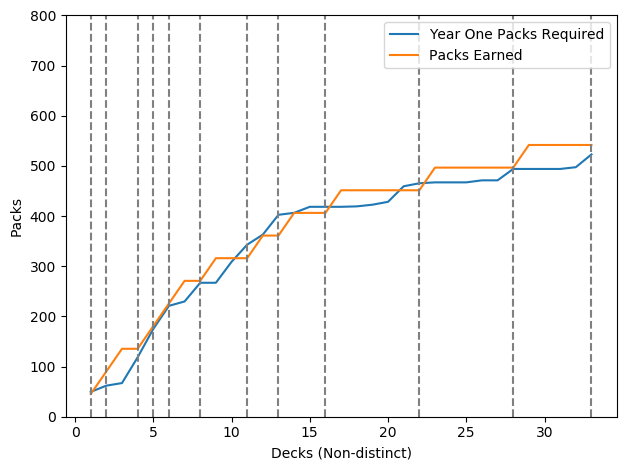

In [14]:
plot(1:length(cumulative_packs_yearone_qc), cumulative_packs_yearone_qc, label = "Year One Packs Required")
plot(1:length(deckmonths), deckmonths * 10.42 * 52/12, label = "Packs Earned")
ylim(0,800)
for i in monthchanges
    axvline(x = i, color = "grey", linestyle = "dashed")
end
legend()
xlabel("Decks (Non-distinct)")
ylabel("Packs")
tight_layout()
savefig("yearone.png")

In [15]:
surplus = last(deckmonths * 10.42 * 52/12 .- cumulative_packs_yearone_qc)

18.851

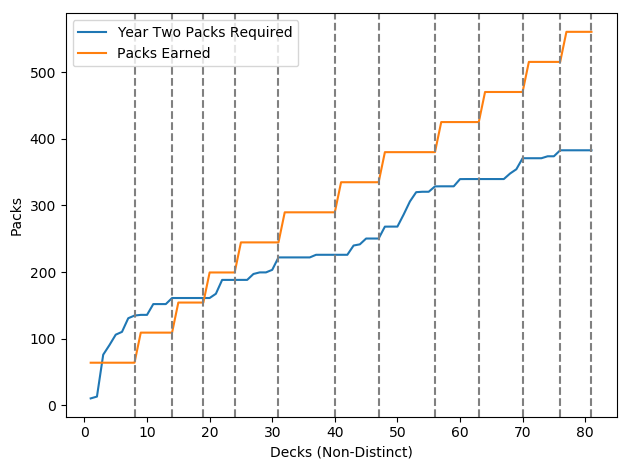

In [16]:
plot(1:length(cumulative_packs_yeartwo_qc), cumulative_packs_yeartwo_qc, label = "Year Two Packs Required")
plot(1:length(deckmonthsfull), surplus .+ deckmonthsfull * 10.42 * 4.333, label = "Packs Earned")
for i in monthchangesfull
    axvline(x = i, color = "grey", linestyle = "dashed")
end
legend()
xlabel("Decks (Non-Distinct)")
ylabel("Packs")
tight_layout()
savefig("yeartwo.png")